In [39]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from workalendar.europe import Belgium
#os.environ['KMP_DUPLICATE_LIB_OK']='True'
#tutorial followed 
#https://towardsdatascience.com/energy-consumption-time-series-forecasting-with-python-and-lstm-deep-learning-model-7952e2f9a796

In [40]:
import pandas as pd
pd.__version__

'1.1.2'

In [41]:
import sys
print(sys.executable)

/home/ubuntu/anaconda3/envs/evgeny/bin/python


In [48]:
holidata = pd.read_csv('./dataB1_weather&holidays_nogaps.csv', index_col=0)
holidata['Datetime'] = pd.to_datetime(holidata.index)
holidata.index = pd.to_datetime(holidata.index)
holidata = holidata.sort_index()
holidata.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 177792 entries, 2014-12-06 00:00:00 to 2019-12-31 23:45:00
Data columns (total 18 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   Valeur             177792 non-null  float64       
 1   working day        177792 non-null  bool          
 2   Temperatures (°C)  177792 non-null  float64       
 3   Radiation (Wh/m²)  177792 non-null  float64       
 4   Wind speed (m/s)   177792 non-null  float64       
 5   hour of day        177792 non-null  int64         
 6   day of week        177792 non-null  int64         
 7   month              177792 non-null  int64         
 8   minutes            177792 non-null  int64         
 9   hour of day_sin    177792 non-null  float64       
 10  hour of day_cos    177792 non-null  float64       
 11  day of week_sin    177792 non-null  float64       
 12  day of week_cos    177792 non-null  float64       
 13  month_sin 

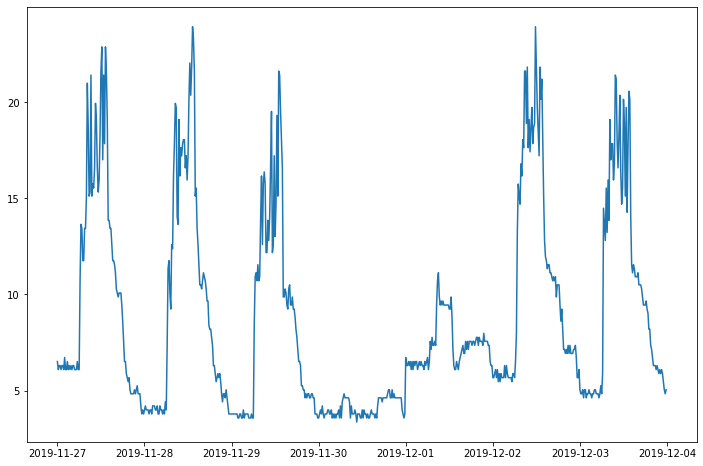

In [54]:
plt.figure(figsize=(12, 8)) 
holidata_user = holidata[-672*5:-672*4]
plt.plot(holidata_user.index, holidata_user.iloc[:,0])

In [ ]:
# Deep learning: 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import CSVLogger
import itertools

class DeepModelTS():
    """
    A class to create a deep time series model
    """
    def __init__(
        self, 
        data: pd.DataFrame, 
        Y_var: str,
        temp_var: str,
        rad_var: str,
        wind_var: str,
        holi_var: str,
        time_var: str,
        hour_var_sin: str,
        hour_var_cos: str,
        day_week_sin: str,
        day_week_cos: str,
        month_sin: str,
        month_cos: str,
        minutes_sin: str,
        minutes_cos: str,
        lag: int,
        LSTM_layer_depth: int, 
        epochs=10, 
        batch_size=256,
        train_test_split=0
    ):

        self.data = data 
        self.Y_var = Y_var 
        self.temp_var = temp_var
        self.rad_var = rad_var
        self.wind_var = wind_var
        self.holi_var = holi_var
        self.time_var = time_var
        self.hour_var_sin = hour_var_sin
        self.hour_var_cos = hour_var_cos
        self.day_week_sin = day_week_sin
        self.day_week_cos = day_week_cos
        self.month_sin = month_sin
        self.month_cos = month_cos
        self.minutes_sin = minutes_sin
        self.minutes_cos = minutes_cos
        self.lag = lag 
        self.LSTM_layer_depth = LSTM_layer_depth
        self.batch_size = batch_size
        self.epochs = epochs
        self.train_test_split = train_test_split

    @staticmethod
    def create_X_Y(ts: list, datetime: list, holiday: list, temperature: list, irradiance: list, wind: list, hour_cos: list, hour_sin: list, week_cos: list, week_sin: list, month_cos: list, month_sin: list, minute_cos: list, minute_sin: list, lag: int) -> tuple:
        """
        A method to create X and Y matrix from a time series list for the training of 
        deep learning models 
        """
        X, Y = [], []
        

        if len(ts) - lag <= 0:
            X.append(ts)
        else:
            for i in range(len(ts) - lag):
                Y.append(ts[i + lag])
                # Substacted 96 for not knowing the day before
                ab = list(itertools.chain([ts[i+lag - 96]], [ts[i+lag - 672]], [holiday[i + lag]], [temperature[i + lag]], [irradiance[i + lag]], [wind[i + lag]], [hour_cos[i + lag]], [hour_sin[i + lag]], [week_cos[i + lag]], [week_sin[i + lag]], [month_cos[i + lag]], [month_sin[i + lag]], [minute_cos[i + lag]], [minute_sin[i + lag]]))
                X.append(ab)
                #X.append(ts[i:(i + lag - 96)] + [holiday[i + lag]] + [hour_cos[i + lag]] + [hour_sin[i + lag]] + )
                #X.append(datetime[i + lag])
                #X.append(holiday[i + lag])
                #X.append(hour_cos[i + lag])
                #X.append(hour_sin[i + lag])
                #X.append(week_cos[i + lag])
                #X.append(week_sin[i + lag])
                #X.append(month_cos[i + lag])
                #X.append(month_sin[i + lag])
      
        
        """
        for i in range(len(ts)):
            Y.append(ts[i])
            X.append(datetime[i])
            X.append(holiday[i])
            X.append(hour_cos[i])
            X.append(hour_sin[i])
            X.append(week_cos[i])
            X.append(week_sin[i])
            X.append(month_cos[i])
            X.append(month_sin[i]) 
        """
        
        X, Y = np.array(X), np.array(Y)

        # Reshaping the X array to an LSTM input shape 
        X = np.reshape(X, (X.shape[0], X.shape[1], 1))

        return X, Y         

    def create_data_for_NN(
        self,
        use_last_n=None
        ):
        """
        A method to create data for the neural network model
        """
        # Extracting the main variable we want to model/forecast
        y = self.data[self.Y_var].tolist()
        y_datetime = self.data[self.time_var].tolist()
        y_holiday = self.data[self.holi_var].tolist()
        y_temp = self.data[self.temp_var].tolist()
        y_rad = self.data[self.rad_var].tolist()
        y_wind = self.data[self.wind_var].tolist()
        y_hour_cos = self.data[self.hour_var_cos].tolist()
        y_hour_sin = self.data[self.hour_var_sin].tolist()
        y_weekday_cos = self.data[self.day_week_cos].tolist()
        y_weekday_sin = self.data[self.day_week_sin].tolist()
        y_month_cos = self.data[self.month_cos].tolist()
        y_month_sin = self.data[self.month_sin].tolist()
        y_minute_cos = self.data[self.minutes_cos].tolist()
        y_minute_sin = self.data[self.minutes_sin].tolist()
        



        # Subseting the time series if needed
        if use_last_n is not None:
            y = y[-use_last_n:]

        # The X matrix will hold the lags of Y 
        X, Y = self.create_X_Y(y, y_datetime, y_holiday, y_temp, y_rad, y_wind, y_hour_cos, y_hour_sin, y_weekday_cos, y_weekday_sin, y_month_cos, y_month_sin, y_minute_cos, y_minute_sin, self.lag)

        # Creating training and test sets 
        X_train = X
        X_test = []

        Y_train = Y
        Y_test = []

        if self.train_test_split > 0:
            index = round(len(X) * self.train_test_split)
            X_train = X[:(len(X) - index)]
            X_test = X[-index:]     
            
            Y_train = Y[:(len(X) - index)]
            Y_test = Y[-index:]
        print(X_train.shape)
        return X_train, X_test, Y_train, Y_test

    def LSTModel(self):
        """
        A method to fit the LSTM model 
        """
        # Getting the data 
        X_train, X_test, Y_train, Y_test = self.create_data_for_NN()
        print(X_train.shape)
        # Defining the model
        model = Sequential()
        model.add(LSTM(self.LSTM_layer_depth, activation='relu', input_shape=(X_train.shape[1],X_train.shape[2])))
        model.add(Dense(1))
        model.compile(optimizer='adam', loss='mse')
        
        # Setting up early stopping
        earlyStop=EarlyStopping(monitor="val_loss",verbose=2,mode='min',patience=3)
        
        # Saving training history
        csv_logger = CSVLogger('training_B2_25ep.log', separator=',', append=False)
        
        # Defining the model parameter dict 
        keras_dict = {
            'x': X_train,
            'y': Y_train,
            'batch_size': self.batch_size,
            'epochs': self.epochs,
            'shuffle': False,
            #'callbacks': [earlyStop, csv_logger]
            'callbacks': [csv_logger]

        }

        if self.train_test_split > 0:
            keras_dict.update({
                'validation_data': (X_test, Y_test)
            })

        # Fitting the model 
        model.fit(
            **keras_dict
        )

        # Saving the model to the class 
        self.model = model

        return model

    def predict(self) -> list:
        """
        A method to predict using the test data used in creating the class
        """
        yhat = []

        if(self.train_test_split > 0):
        
            # Getting the last n time series 
            _, X_test, _, _ = self.create_data_for_NN()        

            # Making the prediction list 
            yhat = [y[0] for y in self.model.predict(X_test)]

        return yhat

    def predict_n_ahead(self, n_ahead: int):
        """
        A method to predict n time steps ahead
        """    
        X, _, _, _ = self.create_data_for_NN(use_last_n=self.lag)        

        # Making the prediction list 
        yhat = []

        for _ in range(n_ahead):
            # Making the prediction
            fc = self.model.predict(X)
            yhat.append(fc)

            # Creating a new input matrix for forecasting
            X = np.append(X, fc)

            # Ommiting the first variable
            X = np.delete(X, 0)

            # Reshaping for the next iteration
            X = np.reshape(X, (1, len(X), 1))

        return yhat    
    
        """def predict_n_ahead(self, data_input, n_ahead: int):
            dates = pd.date_range(self.data.index[-1], periods = n_ahead, freq='15T')[1:]
            #test = self.data.append(pd.DataFrame(index=dates))
            test = data_input
            test.append 
            test['Datetime'] = test.index
            test = preprocess(test)
            y = test[self.holi_var].tolist()
            y_datetime = test[self.time_var].tolist()
            y_holiday = test[self.holi_var].tolist()
            y_hour_cos = test[self.hour_var_cos].tolist()
            y_hour_sin = test[self.hour_var_sin].tolist()
            y_weekday_cos = test[self.day_week_cos].tolist()
            y_weekday_sin = test[self.day_week_sin].tolist()
            y_month_cos = test[self.month_cos].tolist()
            y_month_sin = test[self.month_sin].tolist()
            y_minute_cos = test[self.minutes_cos].tolist()
            y_minute_sin = test[self.minutes_sin].tolist()
            yhat = []
            X, _ = deep_learner.create_X_Y(y, y_datetime, y_holiday, y_hour_cos, y_hour_sin, y_weekday_cos, y_weekday_sin, y_month_cos, y_month_sin, y_minute_cos, y_minute_sin, self.lag)
            yhat = [y[0] for y in self.model.predict(X)]
            return yhat    """

In [ ]:
deep_learner = DeepModelTS(
data = holidata,
Y_var = 'Valeur',
temp_var = 'Temperatures (°C)',
rad_var = 'Radiation (Wh/m²)',
wind_var = 'Wind speed (m/s)',
holi_var = 'working day',
time_var = 'Datetime',
hour_var_sin = 'hour of day_sin',
hour_var_cos = 'hour of day_cos',
day_week_sin = 'day of week_sin',
day_week_cos = 'day of week_cos',
month_sin = 'month_sin',
month_cos = 'month_cos',
minutes_sin = 'minutes_sin',
minutes_cos = 'minutes_cos',
lag = 96,    
LSTM_layer_depth = 50,
epochs = 100,
batch_size = 128,
train_test_split = 0.15
)

In [237]:
# Deep learning: 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import CSVLogger
import itertools

class DeepModelTS():
    """
    A class to create a deep time series model
    """
    def __init__(
        self, 
        data: pd.DataFrame,
        data_user: pd.DataFrame,
        Y_var: str,
        holi_var: str,
        time_var: str,
        hour_var_sin: str,
        hour_var_cos: str,
        day_week_sin: str,
        day_week_cos: str,
        month_sin: str,
        month_cos: str,
        minutes_sin: str,
        minutes_cos: str,
        lag: int,
        lag2: int,
        LSTM_layer_depth: int, 
        epochs=10, 
        batch_size=256,
        train_test_split=0,
        n_test = 96
    ):

        self.data = data
        self.data_user = data_user
        self.Y_var = Y_var 
        self.holi_var = holi_var
        self.time_var = time_var
        self.hour_var_sin = hour_var_sin
        self.hour_var_cos = hour_var_cos
        self.day_week_sin = day_week_sin
        self.day_week_cos = day_week_cos
        self.month_sin = month_sin
        self.month_cos = month_cos
        self.minutes_sin = minutes_sin
        self.minutes_cos = minutes_cos
        self.lag = lag 
        self.lag2 = lag2
        self.LSTM_layer_depth = LSTM_layer_depth
        self.batch_size = batch_size
        self.epochs = epochs
        self.train_test_split = train_test_split
        self.n_test = n_test

    @staticmethod
    def create_X_Y(ts: list, datetime: list, holiday: list, hour_cos: list, hour_sin: list, week_cos: list, week_sin: list, month_cos: list, month_sin: list, minute_cos: list, minute_sin: list, lag: int, lag2: int) -> tuple:
        """
        A method to create X and Y matrix from a time series list for the training of 
        deep learning models 
        """
        X, Y = [], []
        

        if len(ts) - lag <= 0:
            X.append(ts)
        else:
            for i in range(len(ts) - lag):
                Y.append(ts[i + lag])
                # Substacted 96 for not knowing the day before
                ab = list(itertools.chain([holiday[i + lag]], [hour_cos[i + lag]], [hour_sin[i + lag]], [week_cos[i + lag]], [week_sin[i + lag]], [month_cos[i + lag]], [month_sin[i + lag]], [minute_cos[i + lag]], [minute_sin[i + lag]]))
                #ab = list(itertools.chain([ts[i+lag - lag]], [ts[i+lag - lag2]], [holiday[i + lag]], [hour_cos[i + lag]], [hour_sin[i + lag]], [week_cos[i + lag]], [week_sin[i + lag]], [month_cos[i + lag]], [month_sin[i + lag]], [minute_cos[i + lag]], [minute_sin[i + lag]]))
                X.append(ab)
                #X.append(ts[i:(i + lag - 96)] + [holiday[i + lag]] + [hour_cos[i + lag]] + [hour_sin[i + lag]] + )
                #X.append(datetime[i + lag])
                #X.append(holiday[i + lag])
                #X.append(hour_cos[i + lag])
                #X.append(hour_sin[i + lag])
                #X.append(week_cos[i + lag])
                #X.append(week_sin[i + lag])
                #X.append(month_cos[i + lag])
                #X.append(month_sin[i + lag])
      
        
        """
        for i in range(len(ts)):
            Y.append(ts[i])
            X.append(datetime[i])
            X.append(holiday[i])
            X.append(hour_cos[i])
            X.append(hour_sin[i])
            X.append(week_cos[i])
            X.append(week_sin[i])
            X.append(month_cos[i])
            X.append(month_sin[i]) 
        """
        
        X, Y = np.array(X), np.array(Y)

        # Reshaping the X array to an LSTM input shape 
        X = np.reshape(X, (X.shape[0], 1, X.shape[1]))

        return X, Y         

    def create_data_for_NN(
        self,
        use_last_n=None, ahead=False):
        """
        A method to create data for the neural network model
        """
        if ahead == True:
            # Extracting the main variable we want to model/forecast
            y = self.data_user[self.Y_var].tolist()
            y_datetime = self.data_user[self.time_var].tolist()
            y_holiday = self.data_user[self.holi_var].tolist()
            y_hour_cos = self.data_user[self.hour_var_cos].tolist()
            y_hour_sin = self.data_user[self.hour_var_sin].tolist()
            y_weekday_cos = self.data_user[self.day_week_cos].tolist()
            y_weekday_sin = self.data_user[self.day_week_sin].tolist()
            y_month_cos = self.data_user[self.month_cos].tolist()
            y_month_sin = self.data_user[self.month_sin].tolist()
            y_minute_cos = self.data_user[self.minutes_cos].tolist()
            y_minute_sin = self.data_user[self.minutes_sin].tolist()
        else:
            # Extracting the main variable we want to model/forecast
            y = self.data[self.Y_var].tolist()
            y_datetime = self.data[self.time_var].tolist()
            y_holiday = self.data[self.holi_var].tolist()
            y_hour_cos = self.data[self.hour_var_cos].tolist()
            y_hour_sin = self.data[self.hour_var_sin].tolist()
            y_weekday_cos = self.data[self.day_week_cos].tolist()
            y_weekday_sin = self.data[self.day_week_sin].tolist()
            y_month_cos = self.data[self.month_cos].tolist()
            y_month_sin = self.data[self.month_sin].tolist()
            y_minute_cos = self.data[self.minutes_cos].tolist()
            y_minute_sin = self.data[self.minutes_sin].tolist()
        



        # Subseting the time series if needed
        if use_last_n is not None:
            y = y[-use_last_n:]
            y_datetime = y_datetime[-use_last_n:]
            y_holiday = y_holiday[-use_last_n:]
            y_hour_cos = y_hour_cos[-use_last_n:]
            y_hour_sin = y_hour_sin[-use_last_n:]
            y_weekday_cos = y_weekday_cos[-use_last_n:]
            y_weekday_sin = y_weekday_sin[-use_last_n:]
            y_month_cos = y_month_cos[-use_last_n:]
            y_month_sin = y_month_sin[-use_last_n:]
            y_minute_cos = y_minute_cos[-use_last_n:]
            y_minute_sin =  y_minute_sin[-use_last_n:]

        # The X matrix will hold the lags of Y 
        X, Y = self.create_X_Y(y, y_datetime, y_holiday, y_hour_cos, y_hour_sin, y_weekday_cos, y_weekday_sin, y_month_cos, y_month_sin, y_minute_cos, y_minute_sin, self.lag, self.lag2)

        # Creating training and test sets 
        X_train = X
        X_val = []
        X_test = []

        Y_train = Y
        Y_val = []
        Y_test = []
        if ahead == False:
            if self.train_test_split > 0:
                index = round((len(X) - self.n_test) * self.train_test_split)
                X_train = X[:(len(X) - index)]
                X_val = X[(len(X) - index):- self.n_test]
                X_test = X[-self.n_test:]     

                Y_train = Y[:(len(X) - index)]
                Y_val = Y[(len(X) - index):- self.n_test]
                Y_test = Y[-self.n_test:]
        print(X_train.shape)
        print(Y_train.shape)
        return X_train, X_val, X_test, Y_train, Y_val, Y_test

    def LSTModel(self):
        """
        A method to fit the LSTM model 
        """
        # Getting the data 
        X_train, X_val, X_test, Y_train, Y_val, Y_test = self.create_data_for_NN()
        # Defining the model
        model = Sequential()
        model.add(LSTM(self.LSTM_layer_depth, activation='relu', input_shape=(X_train.shape[1],X_train.shape[2])))
        model.add(Dense(1))
        model.compile(optimizer='adam', loss='mse')
        
        # Setting up early stopping
        earlyStop=EarlyStopping(monitor="val_loss",verbose=2,mode='min',patience=3)
        
        # Saving training history
        csv_logger = CSVLogger('training_B2_25ep.log', separator=',', append=False)
        
        # Defining the model parameter dict 
        keras_dict = {
            'x': X_train,
            'y': Y_train,
            'batch_size': self.batch_size,
            'epochs': self.epochs,
            'shuffle': False,
            #'callbacks': [earlyStop, csv_logger]
            'callbacks': [csv_logger]

        }

        if self.train_test_split > 0:
            keras_dict.update({
                'validation_data': (X_val, Y_val)
            })

        # Fitting the model 
        model.fit(
            **keras_dict
        )

        # Saving the model to the class 
        self.model = model

        return model

    def predict(self) -> list:
        """
        A method to predict using the test data used in creating the class
        """
        yhat = []

        if(self.train_test_split > 0):
        
            # Getting the last n time series 
            _, _, X_test, _, _, _ = self.create_data_for_NN()        

            # Making the prediction list 
            yhat = [y[0] for y in self.model.predict(X_test)]

        return yhat

    def predict_n_ahead(self, n_ahead: int):
        """
        A method to predict n time steps ahead
        """    
        X, _, _, _, _, _ = self.create_data_for_NN(use_last_n=self.lag2)   
        print(X.shape)

        # Making the prediction list 
        yhat = []

        for _ in range(n_ahead):
            # Making the prediction
            fc = self.model.predict(X)
            print('fc is')
            print(fc.shape)
            yhat.append(fc)
            
            for i in range(len(ts) - lag):
                Y.append(ts[i + lag])
                # Substacted 96 for not knowing the day before
                ab = list(itertools.chain([ts[i+lag - lag]], [ts[i+lag - lag2]], [holiday[i + lag]], [hour_cos[i + lag]], [hour_sin[i + lag]], [week_cos[i + lag]], [week_sin[i + lag]], [month_cos[i + lag]], [month_sin[i + lag]], [minute_cos[i + lag]], [minute_sin[i + lag]]))
                X.append(ab)
                
            # Creating a new input matrix for forecasting
            X = np.append(X, fc)

            # Ommiting the first variable
            X = np.delete(X, range(self.lag2))

            # Reshaping for the next iteration
            X = np.reshape(X, (X.shape[0], 1, 11))
            #(X.shape[0], 1, X.shape[1])
            print(X.shape)
        yhat = [y[0][0] for y in yhat]
        return yhat    
    
    def predict_n_ahead2(self, data_input, n_ahead: int):
        dates = pd.date_range(self.data.index[-1], periods = n_ahead, freq='15T')[1:]
        test = data_input
        test = test.append(pd.DataFrame(index=dates))
        test['Datetime'] = test.index
        test = preprocess(test)
        y = test[self.holi_var].tolist()
        y_datetime = test[self.time_var].tolist()
        y_holiday = test[self.holi_var].tolist()
        y_hour_cos = test[self.hour_var_cos].tolist()
        y_hour_sin = test[self.hour_var_sin].tolist()
        y_weekday_cos = test[self.day_week_cos].tolist()
        y_weekday_sin = test[self.day_week_sin].tolist()
        y_month_cos = test[self.month_cos].tolist()
        y_month_sin = test[self.month_sin].tolist()
        y_minute_cos = test[self.minutes_cos].tolist()
        y_minute_sin = test[self.minutes_sin].tolist()
        yhat = []
        X, _ = deep_learner.create_X_Y(y, y_datetime, y_holiday, y_hour_cos, y_hour_sin, y_weekday_cos, y_weekday_sin, y_month_cos, y_month_sin, y_minute_cos, y_minute_sin, self.lag, self.lag2)
        print(X.shape)
        yhat = [y[0] for y in self.model.predict(X)]
        return yhat

In [265]:
deep_learner = DeepModelTS(
data = holidata,
data_user = holidata_user, 
Y_var = 'Valeur',
holi_var = 'working day',
time_var = 'Datetime',
hour_var_sin = 'hour of day_sin',
hour_var_cos = 'hour of day_cos',
day_week_sin = 'day of week_sin',
day_week_cos = 'day of week_cos',
month_sin = 'month_sin',
month_cos = 'month_cos',
minutes_sin = 'minutes_sin',
minutes_cos = 'minutes_cos',
lag = 0,
lag2 = 672,
LSTM_layer_depth = 50,
epochs = 100,
batch_size = 128,
train_test_split = 0.05,
n_test = 2688
)

In [266]:
# Fitting the model
model = deep_learner.LSTModel ()

(169037, 1, 9)
(169037,)
Epoch 1/100
1321/1321 [==============================] - 6s 4ms/step - loss: 53.1661 - val_loss: 12.1351
Epoch 2/100
1321/1321 [==============================] - 5s 4ms/step - loss: 20.8955 - val_loss: 11.3168
Epoch 3/100
1321/1321 [==============================] - 5s 4ms/step - loss: 20.1894 - val_loss: 11.2498
Epoch 4/100
1321/1321 [==============================] - 5s 4ms/step - loss: 19.9693 - val_loss: 11.1572
Epoch 5/100
1321/1321 [==============================] - 5s 4ms/step - loss: 19.8164 - val_loss: 11.0933
Epoch 6/100
1321/1321 [==============================] - 5s 4ms/step - loss: 19.7000 - val_loss: 11.0524
Epoch 7/100
1321/1321 [==============================] - 5s 4ms/step - loss: 19.6110 - val_loss: 11.0338
Epoch 8/100
1321/1321 [==============================] - 5s 4ms/step - loss: 19.5405 - val_loss: 11.0217
Epoch 9/100
1321/1321 [==============================] - 5s 4ms/step - loss: 19.4836 - val_loss: 11.0158
Epoch 10/100
1321/1321 [======

1321/1321 [==============================] - 4s 3ms/step - loss: 18.7655 - val_loss: 10.9764
Epoch 79/100
1321/1321 [==============================] - 4s 3ms/step - loss: 18.7610 - val_loss: 10.9734
Epoch 80/100
1321/1321 [==============================] - 4s 3ms/step - loss: 18.7567 - val_loss: 10.9743
Epoch 81/100
1321/1321 [==============================] - 4s 3ms/step - loss: 18.7500 - val_loss: 10.9742
Epoch 82/100
1321/1321 [==============================] - 4s 3ms/step - loss: 18.7451 - val_loss: 10.9741
Epoch 83/100
1321/1321 [==============================] - 4s 3ms/step - loss: 18.7382 - val_loss: 10.9720
Epoch 84/100
1321/1321 [==============================] - 4s 3ms/step - loss: 18.7316 - val_loss: 10.9691
Epoch 85/100
1321/1321 [==============================] - 4s 3ms/step - loss: 18.7255 - val_loss: 10.9682
Epoch 86/100
1321/1321 [==============================] - 5s 4ms/step - loss: 18.7179 - val_loss: 10.9656
Epoch 87/100
1321/1321 [==============================] - 5

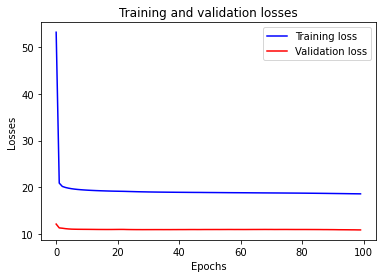

In [267]:
def plot_train_history(model):
    '''
    Convergence plots to have an idea on how the training performs
    '''
    loss = model.history.history['loss']
    val_loss = model.history.history['val_loss']

    plt.figure()
    plt.plot(range(len(loss)), loss, 'b', label='Training loss')
    plt.plot(range(len(val_loss)), val_loss, 'r', label='Validation loss')
    #plt.yscale("log")
    plt.xlabel('Epochs')
    plt.ylabel('Losses')
    plt.title('Training and validation losses')
    plt.legend()
    plt.show()  
plot_train_history(model)

In [255]:
model_json = model.to_json()
with open("model-r_30_B!_c.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model-r_30_B1_c.h5")

In [256]:
from tensorflow.keras.models import model_from_json
# load json and create model
json_file = open("model-r_30_B!_c.json", 'r')
loaded_model_json = json_file.read()
json_file.close()
deep_learner.model = model_from_json(loaded_model_json)
# load weights into new model
deep_learner.model.load_weights("model-r_30_B1_c.h5")
print("Loaded model from disk")

Loaded model from disk


(169037, 1, 9)
(169037,)


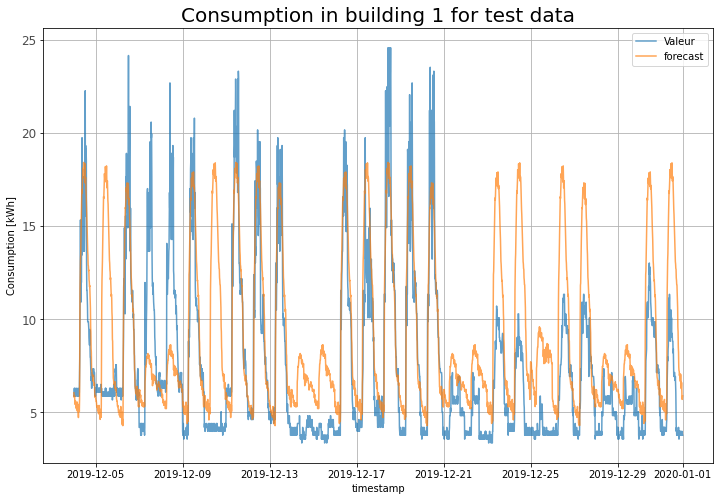

In [268]:
yhat = deep_learner.predict()# Constructing the forecast dataframe
#fc = holidata.nlargest(len(yhat),columns='Datetime').copy()
fc = holidata.tail(len(yhat)).copy()
fc['forecast'] = yhat
#fc['Datetime'] = pd.to_datetime(fc['Datetime'])
# Ploting the forecasts
plt.figure(figsize=(12, 8))
for dtype in ['Valeur', 'forecast']:  
    plt.plot('Datetime',dtype,data=fc,label=dtype,alpha=0.7)
plt.legend()
plt.grid()

plt.gca().set(ylabel='Consumption [kWh]', xlabel='timestamp')
plt.yticks(fontsize=12, alpha=.7)
plt.title("Consumption in building 1 for test data", fontsize=20)

plt.show()

In [27]:
def preprocess(dataframe):
    cal = Belgium()
    years = list(range(2014, 2021))
    holidays = []
    for year in years:
        holidays.extend(cal.holidays(year))
    dataframe['working day'] = dataframe.index.map(cal.is_working_day)
    dataframe['hour of day'] = dataframe.index.hour
    dataframe['day of week'] = dataframe.index.dayofweek
    dataframe['month'] = dataframe.index.month
    dataframe['minutes'] = dataframe.index.minute
    # we encode cynical data into two dimensions using a sine and cosine transformations
    def encode(data, col, max_val):
        data[col + '_sin'] = np.sin(2 * np.pi * data[col]/max_val)
        data[col + '_cos'] = np.cos(2 * np.pi * data[col]/max_val)
        return data
    dataframe = encode(dataframe, 'hour of day', 23)
    dataframe = encode(dataframe, 'day of week', 6)
    dataframe = encode(dataframe, 'month', 12)
    dataframe = encode(dataframe, 'minutes', 60)
    dataframe = dataframe.fillna(method='ffill')
    return dataframe    

(1343, 1, 9)


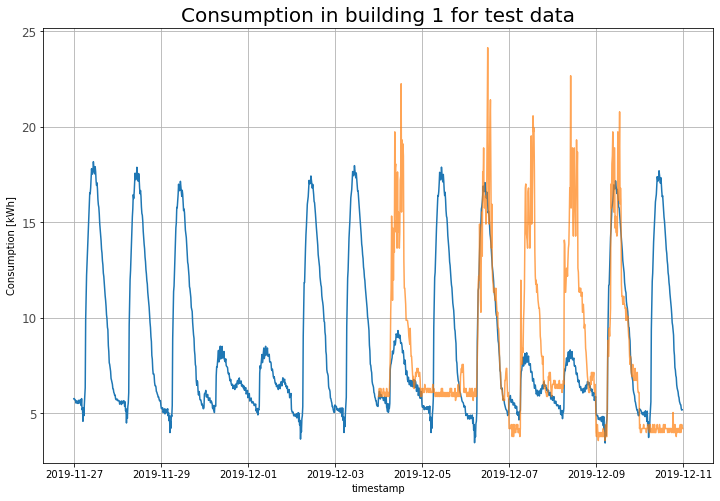

In [264]:
n_ahead = 672
dates = pd.date_range(holidata_user.index[-1], periods = n_ahead, freq='15T')[1:]
test = pd.DataFrame(deep_learner.predict_n_ahead2(holidata_user, n_ahead))
test.index = holidata_user.index.union(dates)
test.index = pd.to_datetime(test.index)
plt.figure(figsize=(12, 8))
plt.grid()
plt.gca().set(ylabel='Consumption [kWh]', xlabel='timestamp')
plt.yticks(fontsize=12, alpha=.7)
plt.title("Consumption in building 1 for test data", fontsize=20)
plt.plot(test.index, test.iloc[:,0])
plt.plot(holidata[-672*4:-672*3].index, holidata[-672*4:-672*3].loc[:,"Valeur"], alpha=0.7)

In [209]:
n_ahead = 672
dates = pd.date_range(holidata_user.index[-1], periods = n_ahead, freq='15T')[1:]
test = pd.DataFrame(deep_learner.predict_n_ahead(n_ahead))
test.index = dates
test.index = pd.to_datetime(test.index)
plt.plot(test.index, test.iloc[:,0])

(576, 1, 11)
(576,)
(576, 1, 11)
fc is
(576, 1)


ValueError: cannot reshape array of size 6336 into shape (6336,1,11)

In [ ]:
testbit.tail(10)

In [ ]:
y_ahead

In [ ]:
plt.figure(figsize=(12, 8)) 
plt.plot(testbit.index,y_ahead)
plt.legend()
plt.grid()

plt.gca().set(ylabel='Consumption [kWh]', xlabel='timestamp')
plt.yticks(fontsize=12, alpha=.7)
plt.title("Consumption in building 1 for test data", fontsize=20)

plt.show()

In [ ]:
fc = fc.set_index('Datetime', drop=False)
fc.index = pd.to_datetime(fc.index)
fc.head()

In [ ]:
data_giles = pd.read_csv('forecasted_demand.csv')
data_giles['Date'] = pd.to_datetime(data_giles['Date'])
data_giles2 = pd.read_csv('forecasted_demand_w2.csv')
data_giles2['Date'] = pd.to_datetime(data_giles2['Date'])
data_giles

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot('Date',"Forecasted consumption kW",data=data_giles2)


In [ ]:
plt.figure(figsize=(12, 8))
for dtype in ['Valeur', 'forecast']:  
    #plt.plot('Datetime',dtype,data=fc['2019-07-15':'2019-07-21'],label=dtype,alpha=0.8)
    plt.plot('Datetime',dtype,data=fc['2019-07-03':'2019-07-09'],label=dtype,alpha=0.8)
    #plt.plot('Datetime',dtype,data=fc[:'2019'],label=dtype,alpha=0.8)
plt.plot('Date',"Forecasted consumption kW",data=data_giles, label='Giles model')
plt.legend()
plt.grid()

plt.rcParams.update({'figure.figsize': (30,20)})
plt.gca().set(ylabel='Consumption [kWh]', xlabel='timestamp')
plt.yticks(fontsize=12, alpha=.7)
plt.title("Next-week load forecast in building 1", fontsize=20)

plt.show()

In [218]:
 def validation(forecasted, real, parameter):
        ''' 
        compute some important parameters to compare forecasting results
        '''
        value = 0
        value_1 = 0
        value_2 = 0
        
        if parameter == 'SMAPE':
            for i in range(len(forecasted)):
                if real[i] + forecasted[i] == 0:
                    value += 0
                else: 
                    value += ((abs(real[i] - forecasted[i])) / (real[i] + forecasted[i])) * 100
            final_value = value / len(forecasted)  
            
        elif parameter == 'MAPE':
            for i in range(len(forecasted)):
                if real[i] == 0:
                    value += 0
                else: 
                    value += (abs(real[i] - forecasted[i]))/real[i]
            final_value = value / len(forecasted) * 100
            
        elif parameter == 'RMSE':
            for i in range(len(forecasted)):
                value += (real[i] - forecasted[i]) ** 2
            final_value = (value / len(forecasted)) ** (1 / 2) 
            
        elif parameter == 'R':
            for i in range(len(forecasted)):
                value += (real[i] - np.mean(real)) * (forecasted[i] - np.mean(forecasted))
                value_1 += (real[i] - np.mean(real)) ** 2
                value_2 += (forecasted[i] - np.mean(forecasted)) ** 2
    
            if value_1 == 0 or value_2 == 0:
                final_value = 100
            else:
                final_value = (value / ((value_1 ** (1 / 2)) * (value_2 ** (1 / 2))))*100
            
        return final_value

In [222]:
#need to MAPE, RMSE and R-correlation factor
#expected = fc.loc['2019-07-03':'2019-07-09','Valeur']
#expected = fc.loc[:'2019-12-21','Valeur']
expected = fc.loc[:,'Valeur']
#predictions = fc.loc['2019-07-03':'2019-07-09','forecast']
#predictions = fc.loc[:'2019-12-21','forecast']
predictions = fc.loc[:,'forecast']
forecast_errors = [expected[i]-predictions[i] for i in range(len(expected))]

In [224]:
print('RMSE: %f [kWh]' % validation(data_giles2["Forecasted consumption kW"],expected, 'RMSE'))
print('MAPE: %f %%' % validation(data_giles2["Forecasted consumption kW"],expected, 'MAPE'))


NameError: name 'data_giles2' is not defined

In [223]:
print('RMSE: %f [kWh]' % validation(predictions,expected, 'RMSE'))
print('MAPE: %f %%' % validation(predictions,expected, 'MAPE'))


RMSE: 3.531492 [kWh]
MAPE: 39.616260 %


In [ ]:
from sklearn.metrics import mean_squared_error
from math import sqrt
mse = mean_squared_error(expected, predictions)
rmse = sqrt(mse)
print('RMSE: %f [kWh]' % rmse)

In [ ]:
def mean_absolute_percentage_error(y_true, y_pred): 
    #y_true, y_pred = check_array(y_true, y_pred)
    np.isfinite(expected).any()
    np.isfinite(predictions).any()
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
mape = mean_absolute_percentage_error(np.array(expected), np.array(predictions))
print('MAPE: %f %%' % mape)

In [ ]:
mape = []
for i in range(1,13):
    expected = fc['Valeur'].loc[fc.index.month == i]
    predictions = fc['forecast'].loc[fc.index.month == i]
    mape.append(mean_absolute_percentage_error(np.array(expected), np.array(predictions)))
data_tuples = list(zip(list(range(1,13)), mape))
months = pd.DataFrame(data_tuples, columns=['month','MAPE'])
plt.figure(figsize=(12, 8))
sns.set_theme(style="whitegrid")
#sns.color_palette('rocket', as_cmap=True)
ax = sns.barplot(x='month', y='MAPE', data = months, palette='crest')
ax.set_ylim([0,100])
plt.title("Mean absolute percentage error by month", fontsize=20)
ax.set(ylabel='MAPE %')

In [ ]:
holidata.info()

In [ ]:
example = holidata.tail(len(yhat)).copy()
#example = holidata.nlargest(len(yhat),columns='Datetime').copy()
plt.figure(figsize=(12, 8))
plt.plot('Datetime','Valeur',data=example,label=dtype,alpha=0.7)
plt.legend()
plt.grid()

plt.gca().set(ylabel='Consumption [kWh]', xlabel='timestamp')
plt.yticks(fontsize=12, alpha=.7)
plt.title("Consumption in building 1 for test data", fontsize=20)

plt.show()